# Linear Elastic Console in 3d

In [1]:
from linkeddeepdict import LinkedDeepDict
from neumann import minmax
import numpy as np

summary = LinkedDeepDict()


def add_to_summary(tag: str, t: float, dofsol: np.ndarray, description: str = None):
    summary[tag]["t"] = t
    summary[tag]["minmax"] = minmax(dofsol)
    if description is not None:
        summary[tag]["description"] = description

In [2]:
# input data
size = Lx, Ly, Lz = (20, 2, 2)
F = -10  # value of the load at the free end
E = 12000.0  # Young's mpdulus
nu = 0.0  # Poisson's ratio
F * Lx**3 / (3 * E * Ly * Lz**3 / 12)

-1.6666666666666667

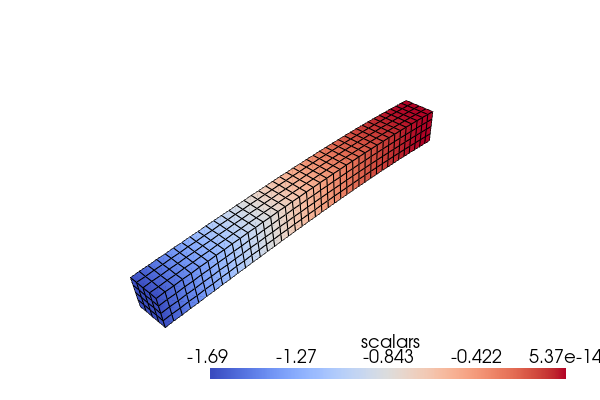

In [3]:
from polymesh.grid import gridH8 as grid
from sigmaepsilon import Structure, PointData, FemMesh
from polymesh.space import PointCloud, StandardFrame
from sigmaepsilon.fem.cells import H8
from neumann import repeat, minmax
from time import time

# generate grid
gridparams = {"size": size, "shape": (40, 4, 4), "origo": (0, 0, 0), "start": 0}
coords, topo = grid(**gridparams)
# place the origo to the center of the cross section
# at the support
pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0.0, 0.0]))
coords = pc.show()
# istoropic material
A = np.array(
    [
        [1, nu, nu, 0, 0, 0],
        [nu, 1, nu, 0, 0, 0],
        [nu, nu, 1, 0, 0, 0],
        [0.0, 0, 0, (1 - nu) / 2, 0, 0],
        [0.0, 0, 0, 0, (1 - nu) / 2, 0],
        [0.0, 0, 0, 0, 0, (1 - nu) / 2],
    ]
) * (E / (1 - nu**2))
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
fixity[:, 3:] = True
# unit vertical load at (Lx, 0, 0)
iF = pc.index_of_closest([Lx, 0.0, 0.0])
loads = np.zeros((coords.shape[0], 6))
loads[iF, 2] = F
# pointdata
GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cd = H8(topo=topo, frames=frames, material=A)
# set up mesh and structure
mesh = FemMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary("H8-6dof", dt, dofsol)
# plot
structure.mesh.pd["x"] = coords + dofsol[:, :3]
mesh.pvplot(
    notebook=True,
    window_size=(600, 400),
    cmap="coolwarm",
    jupyter_backend="static",
    scalars=dofsol[:, 2],
)

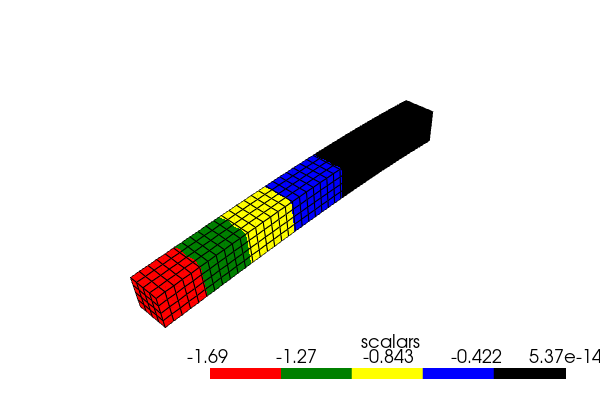

In [11]:
from sigmaepsilon import SolidMesh

# pointdata
fixity = fixity[:, :3]
loads = loads[:, :3]
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cd = H8(topo=topo, material=A, frames=frames)
# set up mesh and structure
mesh = SolidMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary("H8-3dof", dt, dofsol)
#
structure.mesh.pd["x"] = coords + dofsol[:, :3]
cmap = ["black", "blue", "yellow", "green", "red"]
cmap.reverse()
mesh.pvplot(
    notebook=True,
    window_size=(600, 400),
    cmap=cmap,
    jupyter_backend="static",
    scalars=dofsol[:, 2],
)

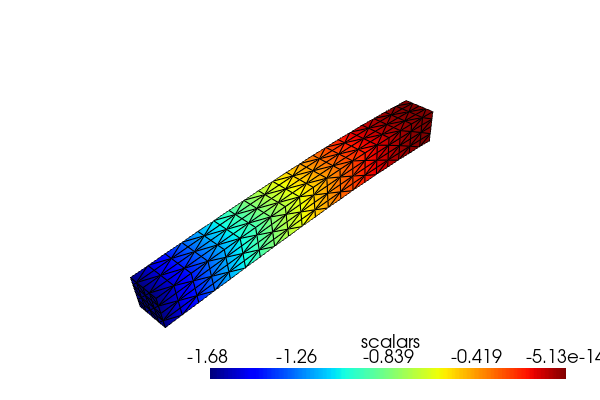

In [12]:
from polymesh.utils.topology import H8_to_H27
from polymesh.utils.space import index_of_closest_point
from sigmaepsilon.fem.cells import H27

# pointdata
gridparams = {"size": size, "shape": (10, 2, 2), "origo": (0, 0, 0), "start": 0}
coords, topo = grid(**gridparams)
pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0.0, 0.0]))
coords = pc.show()
coords, topo = H8_to_H27(coords, topo)
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True
# unit vertical load at (Lx, 0, 0)
iF = index_of_closest_point(coords, np.array([Lx, 0.0, 0.0]))
loads = np.zeros((coords.shape[0], 3))
loads[iF, 2] = F
# pointdata
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
# celldata
cd = H27(topo=topo, material=A, frames=GlobalFrame)
# set up mesh and structure
mesh = SolidMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary("H27-3dof", dt, dofsol)
#
structure.mesh.pd["x"] = coords + dofsol[:, :3]
mesh.pvplot(
    notebook=True,
    window_size=(600, 400),
    cmap="jet",
    jupyter_backend="static",
    scalars=dofsol[:, 2],
)

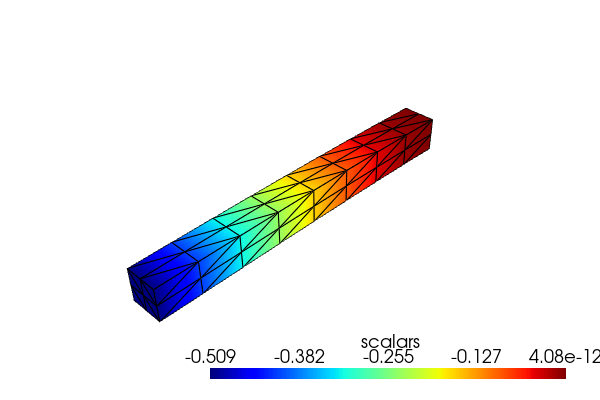

In [13]:
from polymesh.utils.topology import H8_to_TET4
from polymesh.utils.space import index_of_closest_point
from sigmaepsilon.fem.cells import TET4

# pointdata
gridparams = {"size": size, "shape": (8, 2, 2), "origo": (0, 0, 0), "start": 0}
coords, topo = grid(**gridparams)
pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0.0, 0.0]))
coords = pc.show()
coords, topo = H8_to_TET4(coords, topo)
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True
# unit vertical load at (Lx, 0, 0)
iF = index_of_closest_point(coords, np.array([Lx, 0.0, 0.0]))
loads = np.zeros((coords.shape[0], 3))
loads[iF, 2] = F
# pointdata
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
# celldata
cd = TET4(topo=topo, material=A, frames=GlobalFrame)
# set up mesh and structure
mesh = SolidMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary("TET4-3dof-coarse", dt, dofsol)
#
structure.mesh.pd["x"] = coords + dofsol[:, :3]
mesh.pvplot(
    notebook=True,
    window_size=(600, 400),
    cmap="jet",
    jupyter_backend="static",
    scalars=dofsol[:, 2],
)

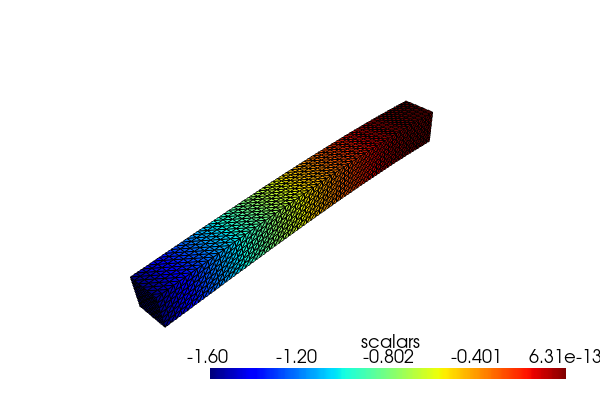

In [14]:
from polymesh.utils.topology import H8_to_TET4
from polymesh.utils.space import index_of_closest_point
from sigmaepsilon.fem.cells import TET4

# pointdata
gridparams = {"size": size, "shape": (60, 6, 6), "origo": (0, 0, 0), "start": 0}
coords, topo = grid(**gridparams)
pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0.0, 0.0]))
coords = pc.show()
coords, topo = H8_to_TET4(coords, topo)
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True
# unit vertical load at (Lx, 0, 0)
iF = index_of_closest_point(coords, np.array([Lx, 0.0, 0.0]))
loads = np.zeros((coords.shape[0], 3))
loads[iF, 2] = F
# pointdata
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
# celldata
cd = TET4(topo=topo, material=A, frames=GlobalFrame)
# set up mesh and structure
mesh = SolidMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary("TET4-3dof-dense", dt, dofsol)
#
structure.mesh.pd["x"] = coords + dofsol[:, :3]
mesh.pvplot(
    notebook=True,
    window_size=(600, 400),
    cmap="jet",
    jupyter_backend="static",
    scalars=dofsol[:, 2],
)

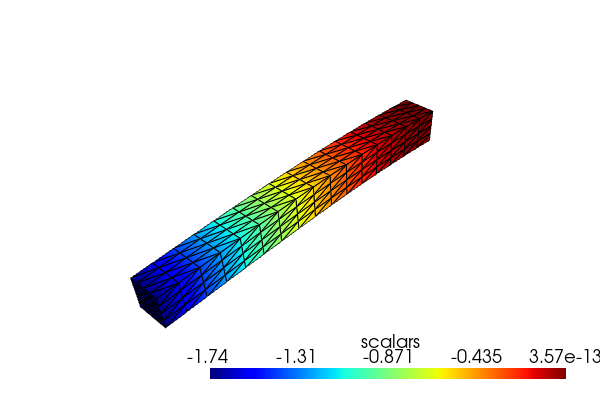

In [15]:
from polymesh.utils.topology import TET4_to_TET10
from polymesh.utils.space import index_of_closest_point
from sigmaepsilon.fem.cells import TET10

# pointdata
gridparams = {"size": size, "shape": (8, 2, 2), "origo": (0, 0, 0), "start": 0}
coords, topo = grid(**gridparams)
pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0.0, 0.0]))
coords = pc.show()
coords, topo = TET4_to_TET10(*H8_to_TET4(coords, topo))
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True
# unit vertical load at (Lx, 0, 0)
iF = index_of_closest_point(coords, np.array([Lx, 0.0, 0.0]))
loads = np.zeros((coords.shape[0], 3))
loads[iF, 2] = F
# pointdata
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
# celldata
cd = TET10(topo=topo, material=A, frames=GlobalFrame)
# set up mesh and structure
mesh = SolidMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)
# solve
_t = time()
structure.linear_static_analysis()
dt = time() - _t
dofsol = structure.nodal_dof_solution()
add_to_summary("TET10-3dof", dt, dofsol)
#
structure.mesh.pd["x"] = coords + dofsol[:, :3]
mesh.pvplot(
    notebook=True,
    window_size=(600, 400),
    cmap="jet",
    jupyter_backend="static",
    scalars=dofsol[:, 2],
)